In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed


In [2]:
# Data biaya dan emisi untuk setiap unit (PV, WT, MT, FC, Battery, Grid)
data_units = {
    "PV": {"cost": 2.584, "emission": 0.0},
    "WT": {"cost": 1.073, "emission": 0.0},
    "MT": {"cost": 0.457, "emission": 720},
    "FC": {"cost": 0.294, "emission": 460},
    "Battery": {"cost": 0.38, "emission": 10},
    "Grid": {"cost": 0.5, "emission": 500},
}


# Fungsi objektif menghitung biaya dan emisi
def objective_function(x):
    total_cost = 0
    total_emission = 0
    units = list(data_units.keys())

    for i, unit in enumerate(units):
        cost = data_units[unit]["cost"] * x[i]
        emission = data_units[unit]["emission"] * x[i]
        total_cost += cost
        total_emission += emission

    fitness = total_cost + total_emission
    
    # print(f"x: {x}")
    # print(f"Total Cost: {total_cost}, Total Emission: {total_emission}")
    # print(f"Fitness: {fitness}")
    # print(f"Total Cost: {total_cost}, Total Emission: {total_emission}, Fitness: {fitness}")
    return fitness, total_cost, total_emission

def initialize_population(pop_size, dim, lb, ub):
    population = np.random.uniform(lb, ub, (pop_size, dim))
    # return population + np.random.normal(0, 0.1, (pop_size, dim))
    return population

def enforce_constraints(x, load_demand, battery_limits):
    total_generated_power = np.sum(x)
    penalty = 0
    if total_generated_power < load_demand:
        # penalty += (load_demand - total_generated_power) * 1000
        # penalty += (load_demand - total_generated_power) ** 2
        penalty_scale = 10  # Skala penalti
        penalty += (load_demand - total_generated_power) ** 2 * penalty_scale

    battery_power = x[list(data_units.keys()).index("Battery")]
    if not (battery_limits[0] <= battery_power <= battery_limits[1]):
        # penalty += abs(battery_power - np.clip(battery_power, battery_limits[0], battery_limits[1])) * 1000
        penalty += abs(battery_power - np.clip(battery_power, battery_limits[0], battery_limits[1])) ** 2

    return penalty

def objective_function_with_constraints(x, load_demand, battery_limits):
    base_fitness, total_cost, total_emission = objective_function(x)
    penalty = enforce_constraints(x, load_demand, battery_limits)
    return base_fitness + penalty, total_cost, total_emission

def plot_convergence_curve(fitness_history, label_name):
    plt.plot(fitness_history, label=label_name)
    plt.title('Grafik Distribusi')
    plt.xlabel('Iterasi')
    plt.ylabel('Fitness')
    plt.legend()
    plt.show()
    
    
    

def generate_pv_output():
    # Distribusi beta untuk radiasi matahari (skala ke 30 kW kapasitas maksimum PV)
    G = np.random.beta(2, 5) * 1000  # Radiasi dalam W/m²
    eta_pv = 0.18  # Efisiensi PV
    A_pv = 10  # Area PV dalam m²
    T_cell = 25  # Suhu panel (°C)
    T_ref = 25  # Suhu referensi (°C)
    gamma = 0.005  # Koefisien suhu PV
    return eta_pv * A_pv * G * (1 - gamma * (T_cell - T_ref)) / 1000  # dalam satuan kW

def generate_wt_output():
    # Distribusi Weibull untuk kecepatan angin (skala ke 30 kW kapasitas maksimum WT)
    v = np.random.weibull(2) * 10  # Kecepatan angin dalam m/s
    rho = 1.225  # Densitas udara (kg/m³)
    A = 20  # Swept area turbin (m²)
    C_p = 0.4  # Koefisien daya turbin
    return 0.5 * rho * A * v**3 * C_p / 1000  # dalam satuan kW

def generate_load_demand(mean=100, std=10):
    # Distribusi normal untuk permintaan beban
    return np.random.normal(mean, std)  # dalam satuan kW

    
# Parameter sistem microgrid
number_of_units = len(data_units)  # PV, WT, MT, FC, Battery, Grid
dim = number_of_units  # Setiap unit memiliki biaya dan emisi
pop_size = 20
max_iter = 100
lb = [0] * number_of_units  # Lower bounds
ub = [30] * number_of_units  # Upper bounds
load_demand = 100 # Permintaan beban contoh (kW)
battery_limits = (-30, 30) # Kapasitas baterai minimum dan maksimum


# Implemntasi Honey Badger Algorithm

In [3]:
def update_density_factor(t, t_max, c=2):
    return c * np.exp(-t / t_max)

def update_position_digging(x, prey_pos, alpha, di, beta=1):
    r3, r4, r5 = np.random.rand(), np.random.rand(), np.random.rand()
    cardioid = np.abs(np.cos(2 * np.pi * r4) * (1 - np.cos(2 * np.pi * r5)))
    # return prey_pos + beta * alpha * di + cardioid * r3
    return x + beta * alpha * (prey_pos - x) + cardioid * r3


def update_position_honey(x, prey_pos, alpha, di):
    r7 = np.random.rand()
    return prey_pos + r7 * alpha * di



def honey_badger_algorithm(obj_func, dim, lb, ub, pop_size, max_iter):
    population = initialize_population(pop_size, dim, lb, ub)
    fitness = np.apply_along_axis(lambda x: obj_func(x)[0], 1, population)
    best_idx = np.argmin(fitness)
    prey_pos = population[best_idx]
    best_fitness = fitness[best_idx]
    best_cost, best_emission = obj_func(prey_pos)[1:]
    fitness_history = []
    cost_history = []
    emission_history = []

    for t in range(max_iter):
        alpha = update_density_factor(t, max_iter)
        for i in range(pop_size):
            di = np.linalg.norm(prey_pos - population[i]) + 1e-6
            F = 1 if np.random.rand() < 0.5 else -1

            if F == 1:
                population[i] = update_position_digging(population[i], prey_pos, alpha, di)
            else:
                population[i] = update_position_honey(population[i], prey_pos, alpha, di)

            population[i] = np.clip(population[i], lb, ub)

        # Evaluasi nilai fitness
        fitness = np.apply_along_axis(lambda x: obj_func(x)[0], 1, population)
        current_best_idx = np.argmin(fitness)
        current_best_fitness = fitness[current_best_idx]

        # Memperbarui solusi terbaik
        if current_best_fitness < best_fitness:
            best_fitness = current_best_fitness
            prey_pos = population[current_best_idx]
            best_cost, best_emission = obj_func(prey_pos)[1:]
            

        # costs = [obj_func(ind)[1] for ind in population]  
        # iter_best_cost = min(costs) 
        fitness_history.append(current_best_fitness)
        cost_history.append(best_cost) 
        emission_history.append(best_emission) 
        
        print(f"Iterasi {t + 1}/{max_iter}, Best Fitness: {best_fitness}")
    
    plot_convergence_curve(fitness_history, 'HBA Fitness')
    return cost_history, emission_history, prey_pos, best_fitness, best_cost, best_emission

def scenario_normal_hba():
    print("Skenario: Operasi Normal")
    lb = [0] * dim
    ub = [30] * dim
    return honey_badger_algorithm(lambda x: objective_function_with_constraints(x, load_demand, battery_limits), dim, lb, ub, pop_size, max_iter)

def scenario_wt_rated_hba():
    print("Skenario: WT pada Daya Terukur")
    lb = [0] * dim
    ub = [30] * dim
    ub[1] = 15  # WT pada daya terukur 15 kW
    return honey_badger_algorithm(lambda x: objective_function_with_constraints(x, load_demand, battery_limits), dim, lb, ub, pop_size, max_iter)

def scenario_pv_wt_rated_hba():
    print("Skenario: PV dan WT pada Daya Nominal")
    lb = [0] * dim
    ub = [30] * dim
    ub[0] = 25  # PV pada daya nominal 25 kW
    ub[1] = 15  # WT pada daya nominal 15 kW
    return honey_badger_algorithm(lambda x: objective_function_with_constraints(x, load_demand, battery_limits), dim, lb, ub, pop_size, max_iter)

def scenario_with_uncertainty_hba():
    print("Skenario: Ketidakpastian PV dan WT")
    fitness_history = []

    # Iterasi untuk simulasi ketidakpastian
    for _ in range(10):  
        # Mensimulasi output PV, WT, dan load demand
        pv_output = generate_pv_output()
        wt_output = generate_wt_output()
        this_load_demand = generate_load_demand()

        # Update batas PV dan WT berdasarkan hasil simulasi
        lb = [0] * dim
        ub = [30] * dim
        ub[0] = pv_output  # PV maksimum sesuai hasil simulasi
        ub[1] = wt_output  # WT maksimum sesuai hasil simulasi
        battery_limits = (-30, 30)  # Kapasitas baterai minimum dan maksimum

        return honey_badger_algorithm(
            lambda x: objective_function_with_constraints(x, this_load_demand, battery_limits),
            dim, lb, ub, pop_size, max_iter
        )
        # fitness_history.append(result[2])  # Simpan fitness terbaik
    


Skenario: Operasi Normal
Iterasi 1/100, Best Fitness: 2971.2122108241833
Iterasi 2/100, Best Fitness: 1452.2730848913993
Iterasi 3/100, Best Fitness: 1421.1100000000001
Iterasi 4/100, Best Fitness: 1421.1100000000001
Iterasi 5/100, Best Fitness: 1421.1100000000001
Iterasi 6/100, Best Fitness: 1421.1100000000001
Iterasi 7/100, Best Fitness: 1421.1100000000001
Iterasi 8/100, Best Fitness: 1421.1100000000001
Iterasi 9/100, Best Fitness: 1421.1100000000001
Iterasi 10/100, Best Fitness: 1421.1100000000001
Iterasi 11/100, Best Fitness: 1421.1100000000001
Iterasi 12/100, Best Fitness: 1421.1100000000001
Iterasi 13/100, Best Fitness: 1421.1100000000001
Iterasi 14/100, Best Fitness: 1421.1100000000001
Iterasi 15/100, Best Fitness: 1421.1100000000001
Iterasi 16/100, Best Fitness: 1421.1100000000001
Iterasi 17/100, Best Fitness: 1421.1100000000001
Iterasi 18/100, Best Fitness: 1421.1100000000001
Iterasi 19/100, Best Fitness: 1421.1100000000001
Iterasi 20/100, Best Fitness: 1421.1100000000001
Iter

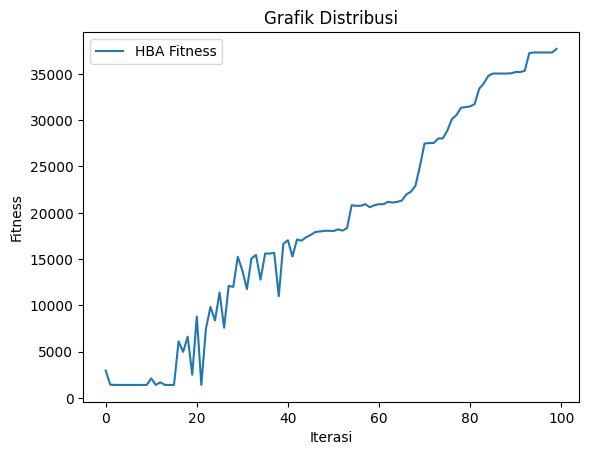

Solusi terbaik (Normal): [30.         30.         22.67090987 22.67090987 30.         22.67090987]
Nilai terbaik (Normal): 1421.1100000000001
Biaya Total: 121.11, Emisi Total: 300.0


In [4]:
cost_history_hba_1, emission_history_hba_1, best_solution_hba, best_value_hba, best_cost_hba, best_emission_hba = scenario_normal_hba()
print("Solusi terbaik (Normal):", best_solution_hba)
print("Nilai terbaik (Normal):", best_value_hba)
print(f"Biaya Total: {best_cost_hba}, Emisi Total: {best_emission_hba}")

Skenario: WT pada Daya Terukur
Iterasi 1/100, Best Fitness: 7115.9507363400535
Iterasi 2/100, Best Fitness: 6655.015
Iterasi 3/100, Best Fitness: 6655.015
Iterasi 4/100, Best Fitness: 6655.015
Iterasi 5/100, Best Fitness: 6655.015
Iterasi 6/100, Best Fitness: 6655.015
Iterasi 7/100, Best Fitness: 6655.015
Iterasi 8/100, Best Fitness: 6655.015
Iterasi 9/100, Best Fitness: 6655.015
Iterasi 10/100, Best Fitness: 6655.015
Iterasi 11/100, Best Fitness: 6655.015
Iterasi 12/100, Best Fitness: 6655.015
Iterasi 13/100, Best Fitness: 6655.015
Iterasi 14/100, Best Fitness: 6655.015
Iterasi 15/100, Best Fitness: 6655.015
Iterasi 16/100, Best Fitness: 6655.015
Iterasi 17/100, Best Fitness: 6655.015
Iterasi 18/100, Best Fitness: 6655.015
Iterasi 19/100, Best Fitness: 6655.015
Iterasi 20/100, Best Fitness: 6655.015
Iterasi 21/100, Best Fitness: 6655.015
Iterasi 22/100, Best Fitness: 6655.015
Iterasi 23/100, Best Fitness: 6655.015
Iterasi 24/100, Best Fitness: 6655.015
Iterasi 25/100, Best Fitness: 66

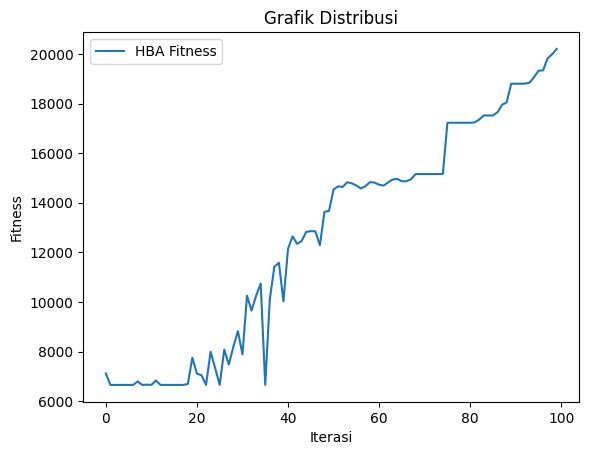

Solusi terbaik (WT Rated): [30.       15.       11.816248 11.816248 30.       11.816248]
Nilai terbaik (WT Rated): 6655.015
Biaya Total: 105.015, Emisi Total: 300.0


In [5]:
cost_history_hba_2, emission_history_hba_2, best_solution_hba, best_value_hba, best_cost_hba, best_emission_hba = scenario_wt_rated_hba()
print("Solusi terbaik (WT Rated):", best_solution_hba)
print("Nilai terbaik (WT Rated):", best_value_hba)
print(f"Biaya Total: {best_cost_hba}, Emisi Total: {best_emission_hba}")

Skenario: PV dan WT pada Daya Nominal
Iterasi 1/100, Best Fitness: 9919.869196982838
Iterasi 2/100, Best Fitness: 9072.53219979553
Iterasi 3/100, Best Fitness: 8912.550459526377
Iterasi 4/100, Best Fitness: 8912.550459526377
Iterasi 5/100, Best Fitness: 8912.550459526377
Iterasi 6/100, Best Fitness: 8912.550459526377
Iterasi 7/100, Best Fitness: 8912.550459526377
Iterasi 8/100, Best Fitness: 8912.550459526377
Iterasi 9/100, Best Fitness: 8912.550459526377
Iterasi 10/100, Best Fitness: 8912.550459526377
Iterasi 11/100, Best Fitness: 8912.550459526377
Iterasi 12/100, Best Fitness: 8912.550459526377
Iterasi 13/100, Best Fitness: 8912.550459526377
Iterasi 14/100, Best Fitness: 8909.772958364169
Iterasi 15/100, Best Fitness: 8907.775496483295
Iterasi 16/100, Best Fitness: 8907.775496483295
Iterasi 17/100, Best Fitness: 8907.775496483295
Iterasi 18/100, Best Fitness: 8907.775496483295
Iterasi 19/100, Best Fitness: 8907.775496483295
Iterasi 20/100, Best Fitness: 8907.775496483295
Iterasi 21/1

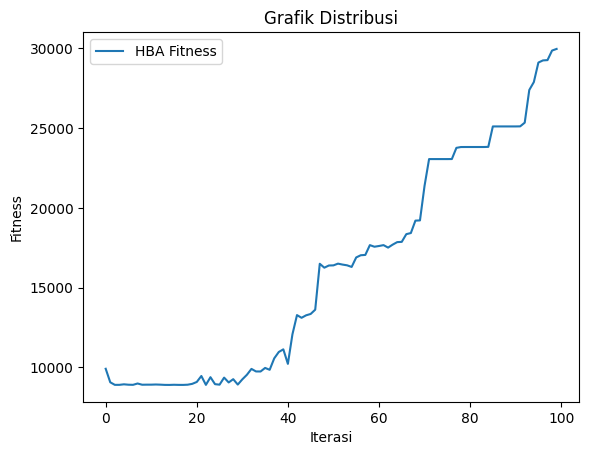

Solusi terbaik (PV dan WT Rated): [25.         15.         15.84968014 22.23292886 30.         15.84968014]
Nilai terbaik (PV dan WT Rated): 8907.775496483295
Biaya Total: 93.9716751250035, Emisi Total: 3236.2944132707576


In [6]:
cost_history_hba_3, emission_history_hba_3, best_solution_hba, best_value_hba, best_cost_hba, best_emission_hba = scenario_pv_wt_rated_hba()
print("Solusi terbaik (PV dan WT Rated):", best_solution_hba)
print("Nilai terbaik (PV dan WT Rated):", best_value_hba)
print(f"Biaya Total: {best_cost_hba}, Emisi Total: {best_emission_hba}")

Skenario: Ketidakpastian PV dan WT
Iterasi 1/100, Best Fitness: 33598.08077956991
Iterasi 2/100, Best Fitness: 33569.05138589672
Iterasi 3/100, Best Fitness: 33569.05138589672
Iterasi 4/100, Best Fitness: 33569.05138589672
Iterasi 5/100, Best Fitness: 33568.633447692315
Iterasi 6/100, Best Fitness: 33561.37488843441
Iterasi 7/100, Best Fitness: 33555.078874014886
Iterasi 8/100, Best Fitness: 33555.07699509885
Iterasi 9/100, Best Fitness: 33555.07699509885
Iterasi 10/100, Best Fitness: 33555.07699509885
Iterasi 11/100, Best Fitness: 33555.07699509885
Iterasi 12/100, Best Fitness: 33555.07699509885
Iterasi 13/100, Best Fitness: 33555.07699509885
Iterasi 14/100, Best Fitness: 33555.07699509885
Iterasi 15/100, Best Fitness: 33555.07699509885
Iterasi 16/100, Best Fitness: 33555.07699509885
Iterasi 17/100, Best Fitness: 33555.07699509885
Iterasi 18/100, Best Fitness: 33555.07699509885
Iterasi 19/100, Best Fitness: 33555.07699509885
Iterasi 20/100, Best Fitness: 33555.07699509885
Iterasi 21/1

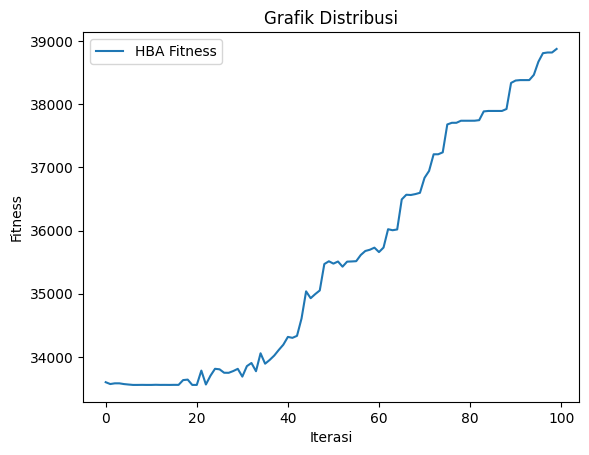

Solusi terbaik (Uncertainty): [ 0.30439493  8.07505344 12.50999559 30.         30.         30.        ]
Nilai terbaik (Uncertainty): 33555.07699509885
Biaya Total: 44.10369644563614, Emisi Total: 28212.243209537344


In [7]:
cost_history_hba_4, emission_history_hba_4, best_solution_hba, best_value_hba, best_cost_hba, best_emission_hba = scenario_with_uncertainty_hba()
print("Solusi terbaik (Uncertainty):", best_solution_hba)
print("Nilai terbaik (Uncertainty):", best_value_hba)
print(f"Biaya Total: {best_cost_hba}, Emisi Total: {best_emission_hba}")

# Implementasi Octopus Algorithm

In [8]:
def adjust_sucker_position(sucker, alpha, local_search_range):
    # dynamic_range = local_search_range * alpha  # Radius pencarian dinamis
    dynamic_range = local_search_range * alpha * (1 + np.random.uniform(-0.5, 0.5))
    return sucker + np.random.uniform(-dynamic_range, dynamic_range, sucker.shape)

def adjust_tentacle_position(tentacle, alpha, prey_pos):
    direction = prey_pos - tentacle
    return tentacle + alpha * direction * np.random.uniform(0, 1, tentacle.shape)

# Regenerasi Tentacle
def enhanced_tentacle_regeneration(tentacle, current_fitness, best_fitness, threshold=0.1):
    if current_fitness > best_fitness * (1 + threshold):  # Jika solusi tidak cukup baik
        return np.random.uniform(lb, ub, tentacle.shape)  # Eksplorasi ulang
    else:
        return tentacle + np.random.uniform(-0.2, 0.2, tentacle.shape) 


def evaluate_fitness(ind, obj_func):
    return obj_func(ind)[0]

def octopus_optimization(obj_func, dim, lb, ub, pop_size, max_iter):
    population = initialize_population(pop_size, dim, lb, ub)
    fitness = np.apply_along_axis(lambda x: obj_func(x)[0], 1, population)
    best_idx = np.argmin(fitness)
    prey_pos = population[best_idx]
    best_fitness = fitness[best_idx]
    best_cost, best_emission = obj_func(prey_pos)[1:]

    suckers = population.copy()
    tentacles = population.copy()
    fitness_history = []
    cost_history = []
    emission_history = []

    for t in range(max_iter):
        alpha = np.exp(-t / max_iter)

        for i in range(pop_size): 
            suckers[i] = adjust_sucker_position(suckers[i], alpha, 0.1)
            # suckers[i] = adjust_sucker_position(suckers[i], alpha, local_search_range)
            suckers[i] = np.clip(suckers[i], lb, ub)

            
            current_fitness = obj_func(tentacles[i])[0]
            tentacles[i] = adjust_tentacle_position(tentacles[i], alpha, prey_pos)
            tentacles[i] = enhanced_tentacle_regeneration(tentacles[i], current_fitness, best_fitness)
            tentacles[i] = np.clip(tentacles[i], lb, ub)

        combined_population = np.vstack((suckers, tentacles))
        combined_fitness = Parallel(n_jobs=-1)(delayed(evaluate_fitness)(ind, obj_func) for ind in combined_population)

        best_combined_idx = np.argmin(combined_fitness)
        current_best_fitness = combined_fitness[best_combined_idx]
        
        # costs = [obj_func(ind)[1] for ind in population]  
        # iter_best_cost = min(costs)  
        # iter_best_fitness = min(fitness)
        # best_cost, best_emission = obj_func(prey_pos)[1:]
        # cost_history.append(best_cost)  
        # print(f"Iterasi {t+1}/{max_iter}, Best Cost: {best_cost}")
        
        if current_best_fitness < best_fitness:
            best_fitness = current_best_fitness
            prey_pos = combined_population[best_combined_idx]
            best_cost, best_emission = obj_func(prey_pos)[1:]
            
        fitness_history.append(current_best_fitness)
        cost_history.append(best_cost) 
        emission_history.append(best_emission)
        
        print(f"Iterasi {t+1}/{max_iter}, Best Fitness: {best_fitness}")
        

    plot_convergence_curve(fitness_history, 'OIO Fitness')

    return cost_history, emission_history, prey_pos, best_fitness, best_cost, best_emission

def scenario_normal_oio():
    print("Skenario: Operasi Normal")
    lb = [0] * number_of_units
    ub = [30] * number_of_units
    return octopus_optimization(lambda x: objective_function_with_constraints(x, load_demand, battery_limits), number_of_units, lb, ub, pop_size, max_iter)

def scenario_wt_rated_oio():
    print("Skenario: WT pada Daya Terukur")
    lb = [0] * number_of_units
    ub = [30] * number_of_units
    ub[1] = 15
    return octopus_optimization(lambda x: objective_function_with_constraints(x, load_demand, battery_limits), number_of_units, lb, ub, pop_size, max_iter)

def scenario_pv_wt_rated_oio():
    print("Skenario: PV dan WT pada Daya Nominal")
    lb = [0] * number_of_units
    ub = [30] * number_of_units
    ub[0] = 25
    ub[1] = 15
    return octopus_optimization(lambda x: objective_function_with_constraints(x, load_demand, battery_limits), number_of_units, lb, ub, pop_size, max_iter)

def scenario_with_uncertainty_oio():
    print("Skenario: Ketidakpastian PV dan WT")
    fitness_history = []

    # Iterasi untuk simulasi ketidakpastian
    for _ in range(10): 
        # Mensimulasikan output PV, WT, dan load demand
        pv_output = generate_pv_output()
        wt_output = generate_wt_output()
        this_load_demand = generate_load_demand()

        # Update batas PV dan WT berdasarkan hasil simulasi
        lb = [0] * dim
        ub = [30] * dim
        ub[0] = pv_output  # PV maksimum sesuai hasil simulasi
        ub[1] = wt_output  # WT maksimum sesuai hasil simulasi
        battery_limits = (-30, 30)  # Kapasitas baterai minimum dan maksimum

        return octopus_optimization(
            lambda x: objective_function_with_constraints(x, this_load_demand, battery_limits),
            dim, lb, ub, pop_size, max_iter
        )

Skenario: Operasi Normal
Iterasi 1/100, Best Fitness: 10675.036278097712
Iterasi 2/100, Best Fitness: 10485.423727171557
Iterasi 3/100, Best Fitness: 10423.98456825334
Iterasi 4/100, Best Fitness: 10349.670368203808
Iterasi 5/100, Best Fitness: 10349.670368203808
Iterasi 6/100, Best Fitness: 10349.670368203808
Iterasi 7/100, Best Fitness: 9355.164848015638
Iterasi 8/100, Best Fitness: 9355.164848015638
Iterasi 9/100, Best Fitness: 9344.655467638382
Iterasi 10/100, Best Fitness: 9254.971192909556
Iterasi 11/100, Best Fitness: 9254.971192909556
Iterasi 12/100, Best Fitness: 9254.971192909556
Iterasi 13/100, Best Fitness: 9093.550086525758
Iterasi 14/100, Best Fitness: 9087.670168910581
Iterasi 15/100, Best Fitness: 9025.164286806445
Iterasi 16/100, Best Fitness: 8939.135567939502
Iterasi 17/100, Best Fitness: 8829.807523960517
Iterasi 18/100, Best Fitness: 8829.807523960517
Iterasi 19/100, Best Fitness: 8829.807523960517
Iterasi 20/100, Best Fitness: 8793.465751567332
Iterasi 21/100, Bes

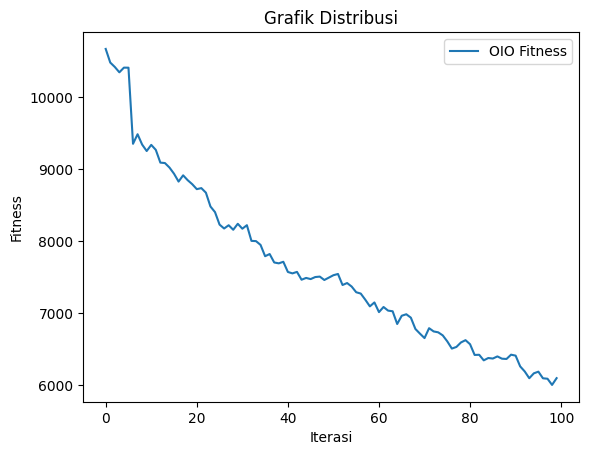

Solusi terbaik (Normal): [28.8283663  29.43510599  0.13804339  5.27867382 19.31035755  1.54938771]
Nilai terbaik (Normal): 6001.318813646452
Biaya Total: 115.80401290100882, Emisi Total: 3495.3786281495277


In [9]:
cost_history_oio_1, emission_history_oio_1, best_solution, best_value, best_cost, best_emission = scenario_normal_oio()
print("Solusi terbaik (Normal):", best_solution)
print("Nilai terbaik (Normal):", best_value)
print(f"Biaya Total: {best_cost}, Emisi Total: {best_emission}")

Skenario: WT pada Daya Terukur
Iterasi 1/100, Best Fitness: 11403.963313203238
Iterasi 2/100, Best Fitness: 11368.812841429184
Iterasi 3/100, Best Fitness: 11366.134676552847
Iterasi 4/100, Best Fitness: 11366.134676552847
Iterasi 5/100, Best Fitness: 11366.134676552847
Iterasi 6/100, Best Fitness: 11366.134676552847
Iterasi 7/100, Best Fitness: 11366.134676552847
Iterasi 8/100, Best Fitness: 11366.134676552847
Iterasi 9/100, Best Fitness: 11329.549948166805
Iterasi 10/100, Best Fitness: 11329.549948166805
Iterasi 11/100, Best Fitness: 11329.549948166805
Iterasi 12/100, Best Fitness: 11329.549948166805
Iterasi 13/100, Best Fitness: 11329.549948166805
Iterasi 14/100, Best Fitness: 11329.549948166805
Iterasi 15/100, Best Fitness: 11329.549948166805
Iterasi 16/100, Best Fitness: 11329.549948166805
Iterasi 17/100, Best Fitness: 11317.489570472379
Iterasi 18/100, Best Fitness: 11282.85726624489
Iterasi 19/100, Best Fitness: 11282.85726624489
Iterasi 20/100, Best Fitness: 11282.85726624489
I

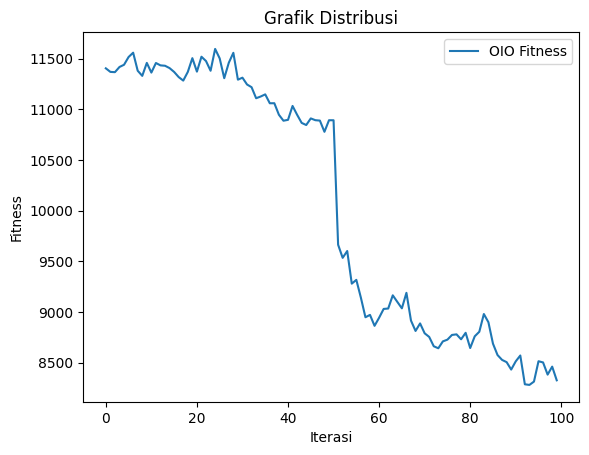

Solusi terbaik (WT Rated): [29.83410969 15.          0.18046875  0.12264195 26.96210864  1.53836054]
Nilai terbaik (WT Rated): 8279.187920998722
Biaya Total: 104.31965194076312, Emisi Total: 1225.1541559903985


In [10]:
cost_history_oio_2, emission_history_oio_2, best_solution, best_value, best_cost, best_emission = scenario_wt_rated_oio()
print("Solusi terbaik (WT Rated):", best_solution)
print("Nilai terbaik (WT Rated):", best_value)
print(f"Biaya Total: {best_cost}, Emisi Total: {best_emission}")

Skenario: PV dan WT pada Daya Nominal
Iterasi 1/100, Best Fitness: 19012.926251407407
Iterasi 2/100, Best Fitness: 17485.410020947966
Iterasi 3/100, Best Fitness: 16052.95996932151
Iterasi 4/100, Best Fitness: 16052.95996932151
Iterasi 5/100, Best Fitness: 15989.847297317445
Iterasi 6/100, Best Fitness: 15989.847297317445
Iterasi 7/100, Best Fitness: 15390.513628171779
Iterasi 8/100, Best Fitness: 15364.159015465648
Iterasi 9/100, Best Fitness: 13585.688955069238
Iterasi 10/100, Best Fitness: 13548.69699043854
Iterasi 11/100, Best Fitness: 13548.69699043854
Iterasi 12/100, Best Fitness: 13548.69699043854
Iterasi 13/100, Best Fitness: 13548.69699043854
Iterasi 14/100, Best Fitness: 13548.69699043854
Iterasi 15/100, Best Fitness: 13548.69699043854
Iterasi 16/100, Best Fitness: 13481.519111489593
Iterasi 17/100, Best Fitness: 13403.959137860846
Iterasi 18/100, Best Fitness: 13341.987043053006
Iterasi 19/100, Best Fitness: 13341.987043053006
Iterasi 20/100, Best Fitness: 13331.136039875744

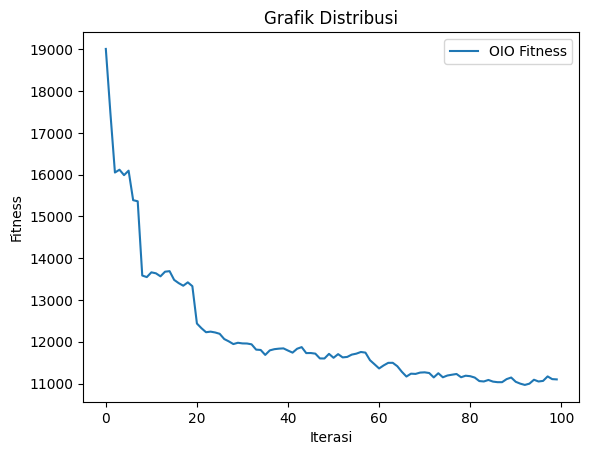

Solusi terbaik (PV dan WT Rated): [24.8270795  15.          0.07073795 15.53637759 27.77685479  2.96704357]
Nilai terbaik (PV dan WT Rated): 10966.293292826933
Biaya Total: 96.88692228031711, Emisi Total: 8958.955351085122


In [11]:
cost_history_oio_3, emission_history_oio_3, best_solution, best_value, best_cost, best_emission = scenario_pv_wt_rated_oio()
print("Solusi terbaik (PV dan WT Rated):", best_solution)
print("Nilai terbaik (PV dan WT Rated):", best_value)
print(f"Biaya Total: {best_cost}, Emisi Total: {best_emission}")

Skenario: Ketidakpastian PV dan WT
Iterasi 1/100, Best Fitness: 32287.86949823247
Iterasi 2/100, Best Fitness: 30378.414435036477
Iterasi 3/100, Best Fitness: 27885.558162557507
Iterasi 4/100, Best Fitness: 27873.308597479037
Iterasi 5/100, Best Fitness: 27873.308597479037
Iterasi 6/100, Best Fitness: 27648.214347479436
Iterasi 7/100, Best Fitness: 27648.214347479436
Iterasi 8/100, Best Fitness: 27547.15351472349
Iterasi 9/100, Best Fitness: 27418.790791534535
Iterasi 10/100, Best Fitness: 27379.664158251588
Iterasi 11/100, Best Fitness: 27379.664158251588
Iterasi 12/100, Best Fitness: 27194.31507452183
Iterasi 13/100, Best Fitness: 27194.31507452183
Iterasi 14/100, Best Fitness: 27194.31507452183
Iterasi 15/100, Best Fitness: 27194.31507452183
Iterasi 16/100, Best Fitness: 27132.678480771712
Iterasi 17/100, Best Fitness: 27132.678480771712
Iterasi 18/100, Best Fitness: 27093.458361911013
Iterasi 19/100, Best Fitness: 27093.458361911013
Iterasi 20/100, Best Fitness: 27093.458361911013


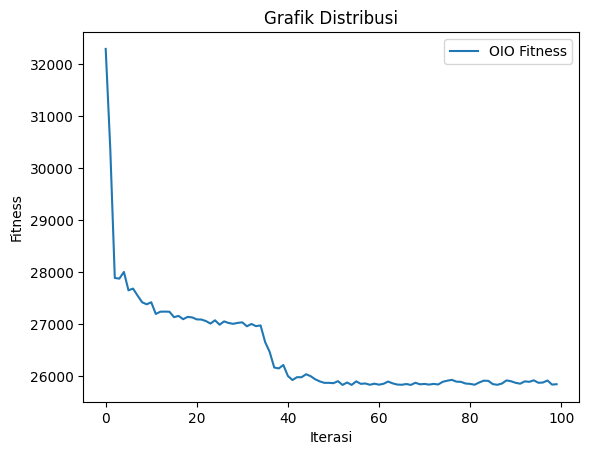

Solusi terbaik (Uncertainty): [ 0.72277223  0.13357228  0.         28.15911848 30.         13.21809585]
Nilai terbaik (Uncertainty): 25830.217150482094
Biaya Total: 28.29879526937973, Emisi Total: 19862.242425014745


In [12]:
cost_history_oio_4, emission_history_oio_4, best_solution_oio, best_value_oio, best_cost_oio, best_emission_oio = scenario_with_uncertainty_oio()
print("Solusi terbaik (Uncertainty):", best_solution_oio)
print("Nilai terbaik (Uncertainty):", best_value_oio)
print(f"Biaya Total: {best_cost_oio}, Emisi Total: {best_emission_oio}")

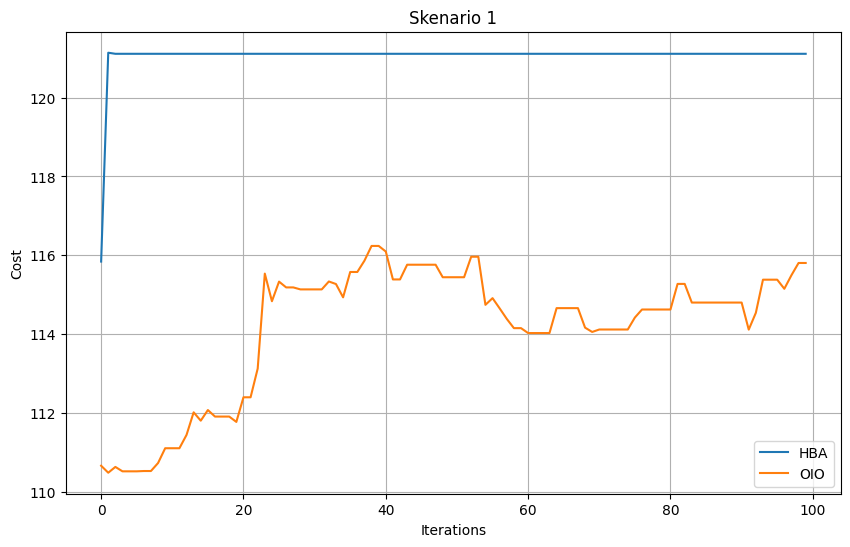

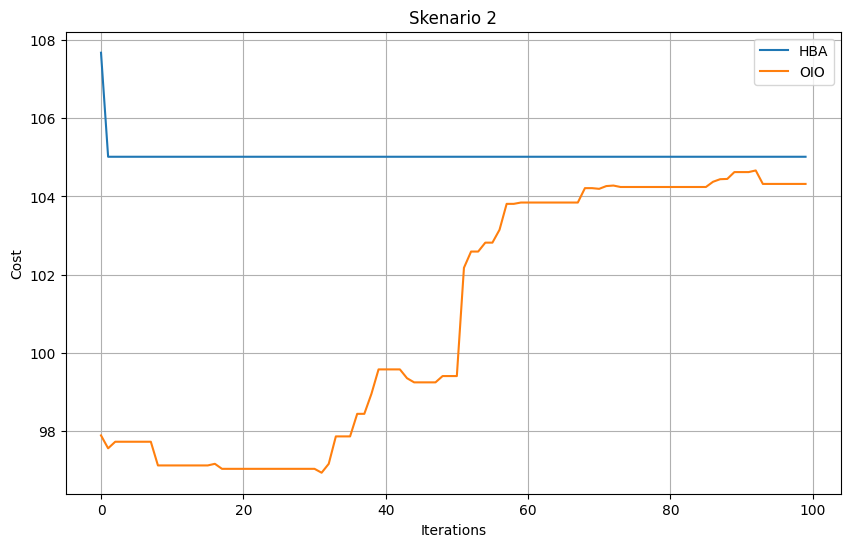

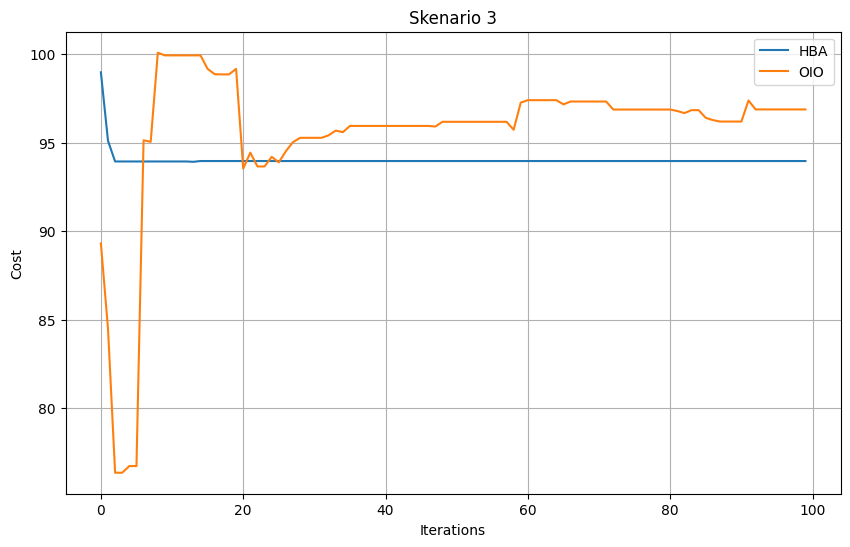

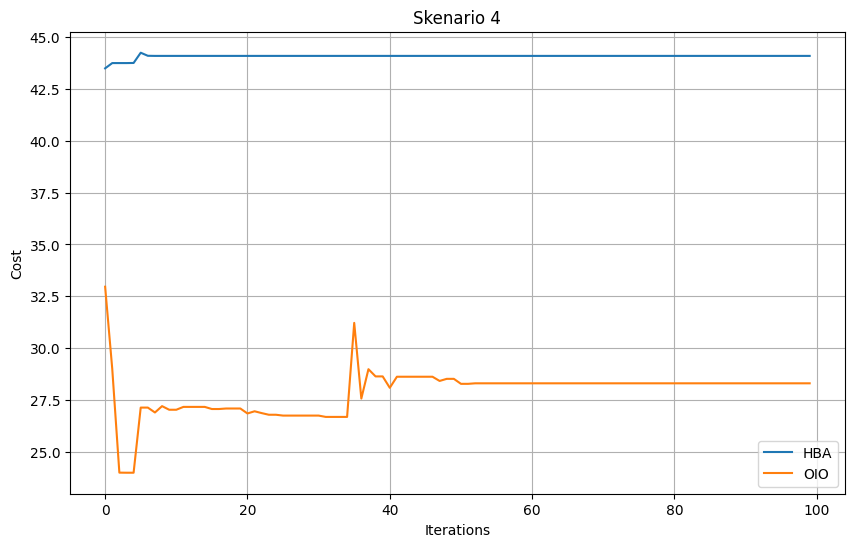

In [13]:
def plot_convergence(fitness_history_hba, fitness_history_oio, elemen_name, title="Grafik Perbandingan Konvergensi Algoritma"):
    plt.figure(figsize=(10, 6))  

    plt.plot(fitness_history_hba, label="HBA")
    plt.plot(fitness_history_oio, label="OIO")

    plt.title(title)
    plt.xlabel("Iterations")
    plt.ylabel(elemen_name)
    plt.legend()
    plt.grid()
    plt.show()

# plot_convergence(fitness_history_hba_1, fitness_history_oio_1, title="Convergence Comparison for Scenario 1")
plot_convergence(cost_history_hba_1, cost_history_oio_1, "Cost", title="Skenario 1")
plot_convergence(cost_history_hba_2, cost_history_oio_2, "Cost", title="Skenario 2")
plot_convergence(cost_history_hba_3, cost_history_oio_3, "Cost", title="Skenario 3")
plot_convergence(cost_history_hba_4, cost_history_oio_4, "Cost", title="Skenario 4")




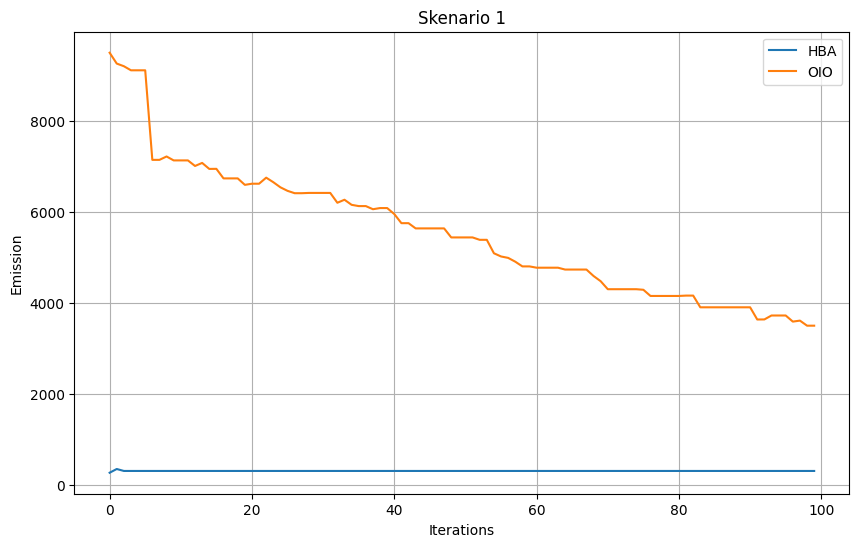

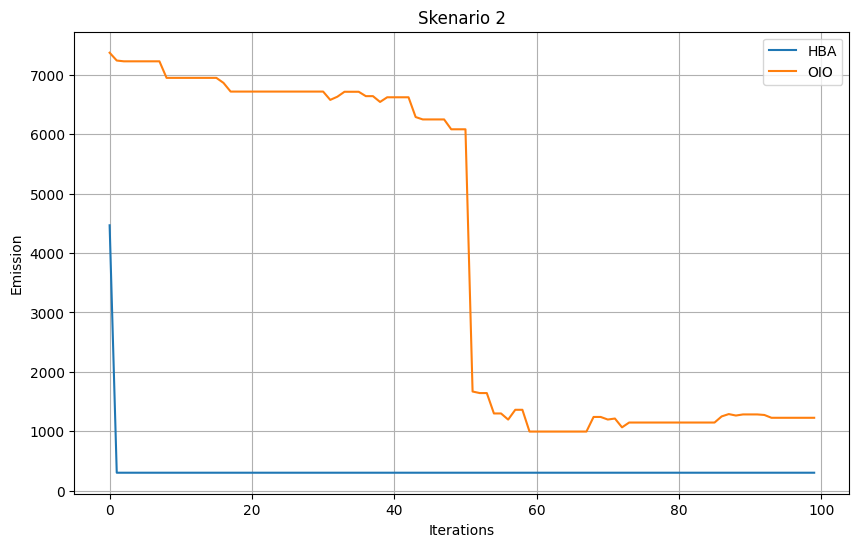

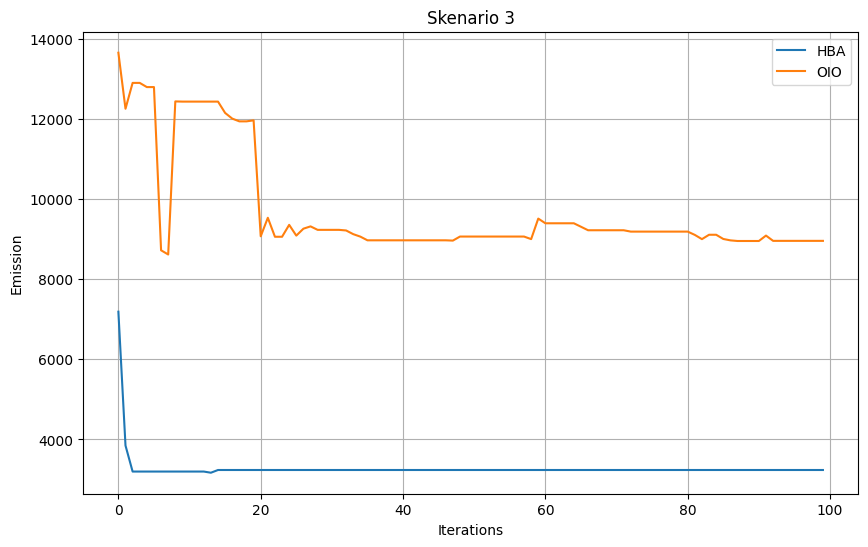

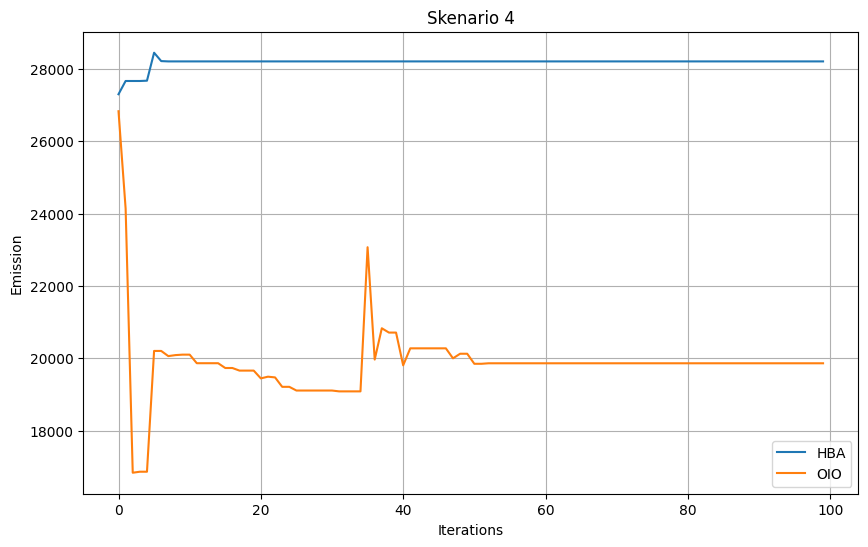

In [14]:
# plot_convergence(fitness_history_hba_1, fitness_history_oio_1, title="Convergence Comparison for Scenario 1")
plot_convergence(emission_history_hba_1, emission_history_oio_1, "Emission", title="Skenario 1")
plot_convergence(emission_history_hba_2, emission_history_oio_2, "Emission", title="Skenario 2")
plot_convergence(emission_history_hba_3, emission_history_oio_3, "Emission", title="Skenario 3")
plot_convergence(emission_history_hba_4, emission_history_oio_4, "Emission", title="Skenario 4")


